# Entrega final - Competencia 03 de Kaggle

- Explicación de los procesos afectuados
- Justificación de selección del "mejor" modelo
- Entrega adicional con promedios entre semilleríos

Alumno: Santiago Tedoldi

Comisión lunes

In [ ]:
# Librerias
import pandas as pd
import numpy as np

## Explicación de los procesos

### Definición del target

Trabajé usando un script de SQL con duckdb, según lo visto en la comisión de los lunes:

Notebook: comp03_target

### Preprocesamiento de los datos (prepro)

Tomando de base lo visto en la comisión de los lunes, y con ayuda de los notebooks de Ian Michel Link, evalué la calidad de los datos (nulos, zeros) y el data drifting observando los **últimos 6 meses de datos**.

Además, a las variables monetarias les aplique un proceso de corrección por deflación.

Notebook: comp03_prepro_6x

### Ingeniería de variables (fe)

**Enfoque conceptual en 6 meses + Lag1 + Delta1**, agregando para las demás variables lags y deltas de un mes previo. (~660 variables)

Notebook: comp03_fe6_6x

Luego, probé agregar **Lag2 y Delta2**, según el script "linea de muerte" compartido por la cátedra.

Notebook: comp03_fe6_6xx

### Optimización bayesiana (opt)

Trabajé con optuna, optimizando de forma local (con un subsampleo de la clase CONTINUA del 10 % y con 12 meses de datos).

Cómo en la nube tardaba demesiado, solo logré entrenar un par de trials. La optimización local fue sobre un total de 60 iteraciones.

> lightgbm (local y en la nube)

Optimización local, con 60 iteraciones:

In [ ]:
{
    'n_estimators': 586,
    'num_leaves': 72,
    'learning_rate': 0.03225820947502308,
    'min_data_in_leaf': 182,
    'feature_fraction': 0.5612204369575097
}

En un back-testing de [202008, 202009, 202010, 202011, 202012, 202101, 202102, 202103, 202104, 202105] vs 202107:

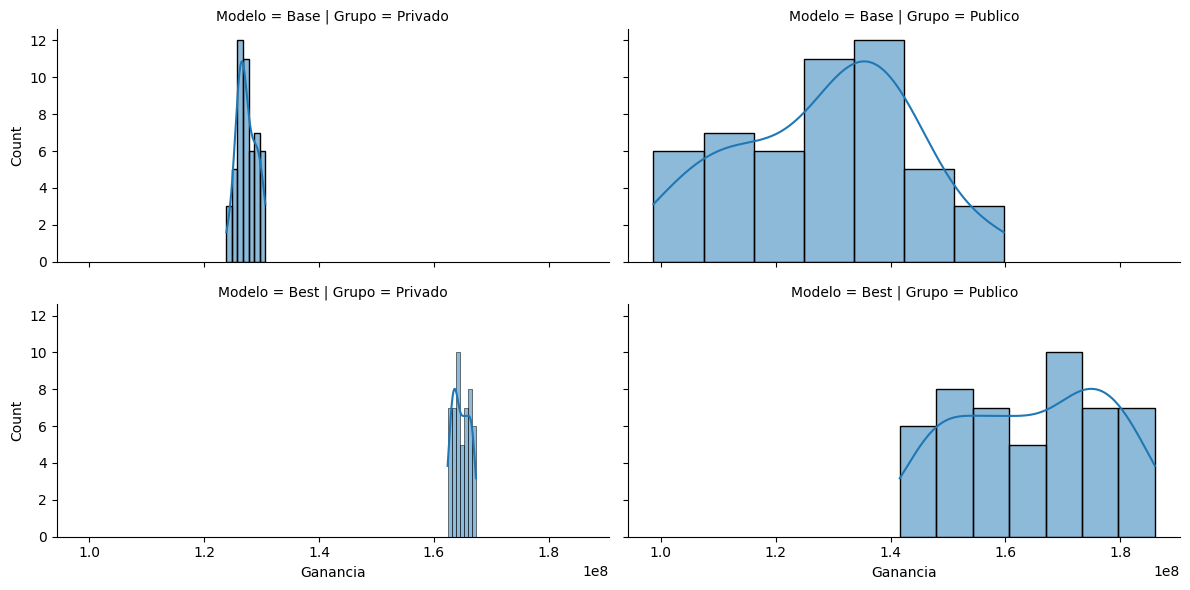

Ganancia media del modelo base en privado: 127355355.5

Ganancia media del modelo base en público: 128221800.0

Ganancia media del modelo Best en privado: 164743444.4

Ganancia media del modelo Best en público: 164969000.0

Optimización en nube (poca iteraciones)

In [ ]:
{
    'n_estimators': 522, 
    'num_leaves': 75, 
    'learning_rate': 0.015228897239224944, 
    'min_data_in_leaf': 157, 
    'feature_fraction': 0.47007968576605774
}

En un back-testing de [202008, 202009, 202010, 202011, 202012, 202101, 202102, 202103, 202104, 202105] vs 202107:

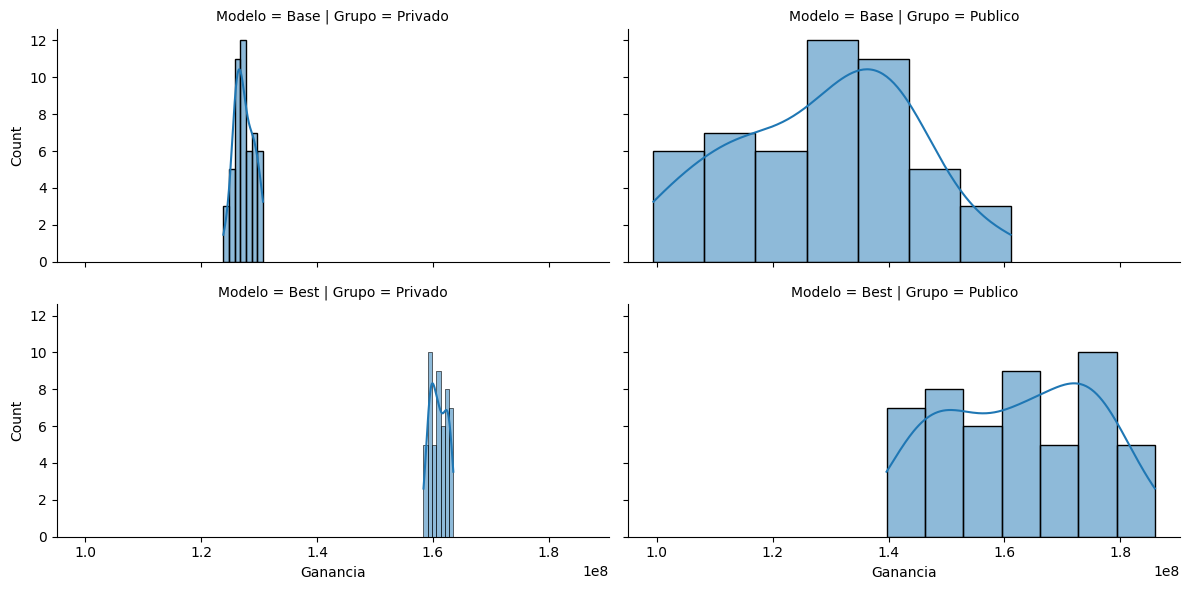

Ganancia media del modelo base en privado: 127421933.3

Ganancia media del modelo base en público: 128532600.0

Ganancia media del modelo Best en privado: 160979000.0

Ganancia media del modelo Best en público: 162519000.0

## Comparación de pipelines

### Comparación de modelos optimizados

> Optimización local

> Optimización nube

Notebook: comp03_pipeline_comp

Comparando los modelos optimizados en un back-testing de [202008, 202009, 202010, 202011, 202012, 202101, 202102, 202103, 202104, 202105] vs 202107:

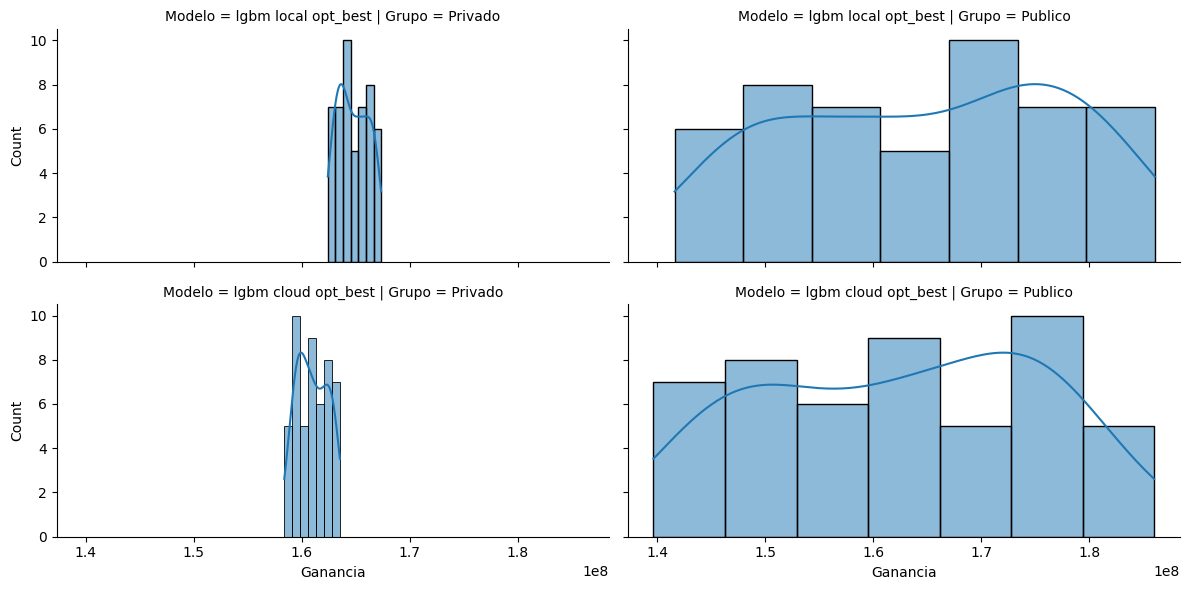

En este caso, ni siquiera hace falta un test para elegir al modelo lgbm local opt. Sin embargo, dado que el split es de 10 %, la diferencia en el score público es practicamente imperceptible.

### Comparación de nuevo modelo con el de la comp02

Notebook: comp03_comp_lastdacen

> lgbm prepro6 fe6 y 12 opt (local opt 10 % de CONTINUA)

> xgb prepro6 fe6 comp02

Según:

10 meses de back-testing


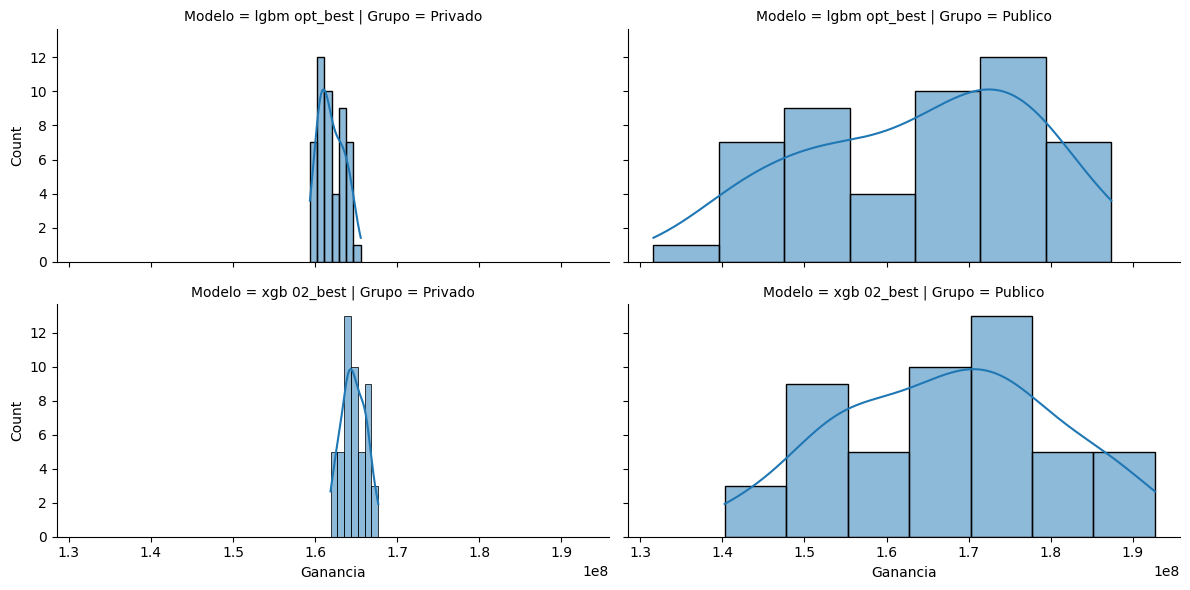

Normalizando variables de montos y transacciones

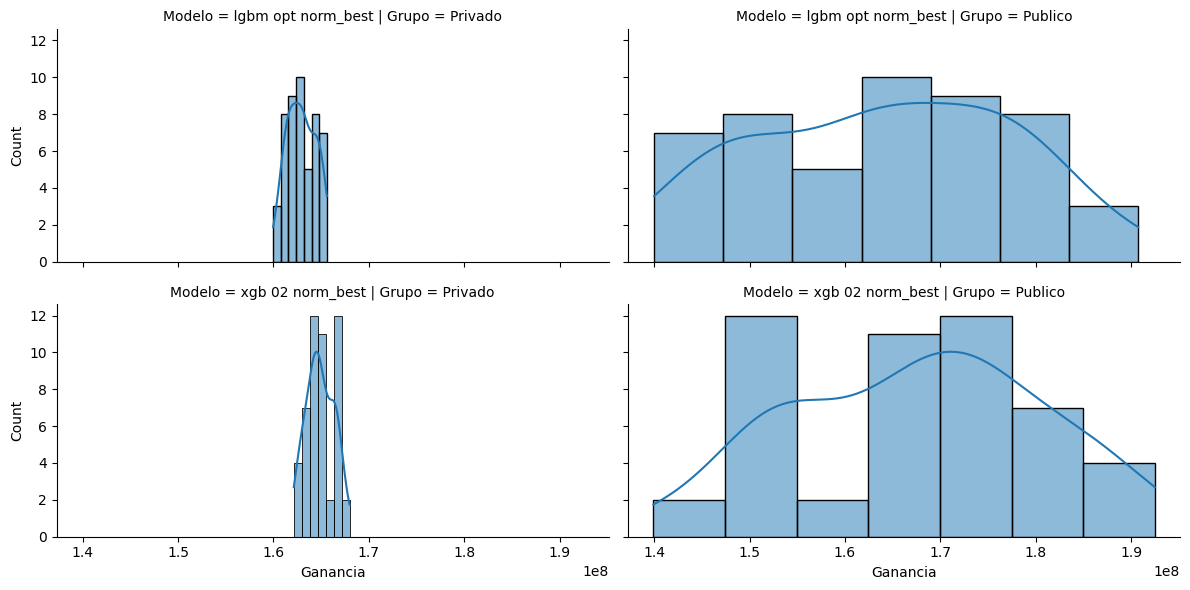

Usando todos los meses (descartando pandemia y meses con datos rotos):

mes_bt_train_all = [
                    # 201901, 201902, 201903, 201904, 201906, 201907, # no los agregó por rotura de variables creadas
                    201908, 201909, 201911, 201912, 202001, 202002, 
                    202003, 202008, 202009, 202010, 202011, 202012,
                    202101, 202102, 202103, 202104, 202105
                    ] # igualmente habra variables perturbadas en los meses que no son tenidos en cuenta

vs. 202107

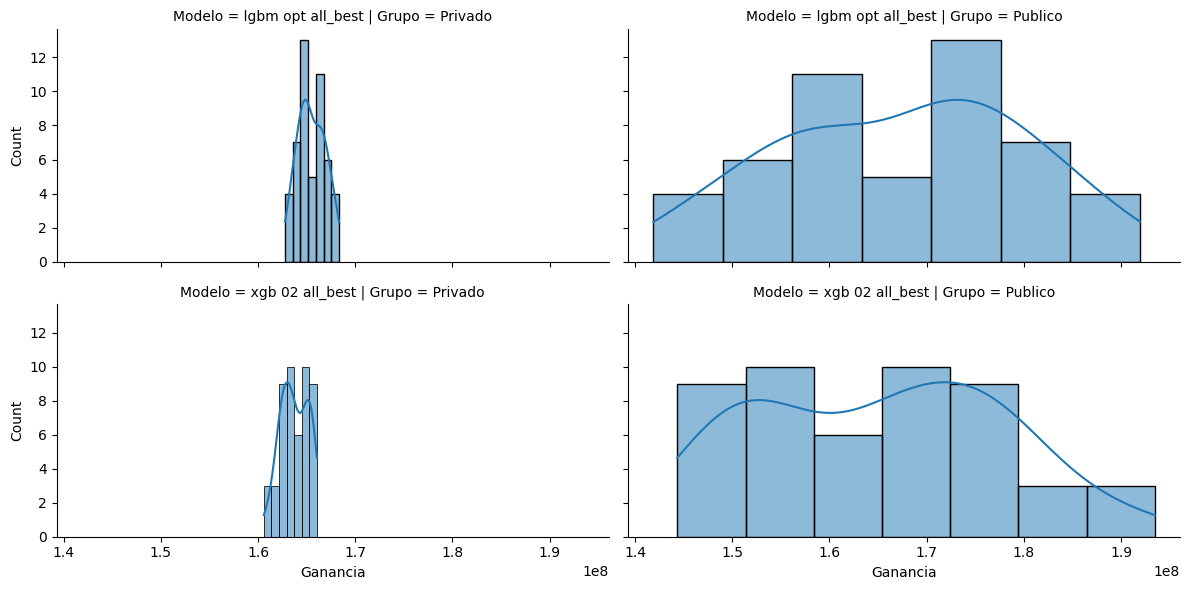

> CONCLUSION:

La optimización local es superior a la hecha en la nube.

En 10 meses, el xgb de la comp02 parece mejor que el lgbm.

La normalización (sin ser incluída en la optimización) no afecta significativamente a los resultados.

El uso de más meses mejora al lgbm, volviéndolo superior al xgb comp02.

Se optó por elegir el lgbm optizado localmente, con todos los meses para el trian y sin normalizar.

### Comparación SIN / CON lag2 y delta2

Notebook: comp03_comp_lastdacenxx

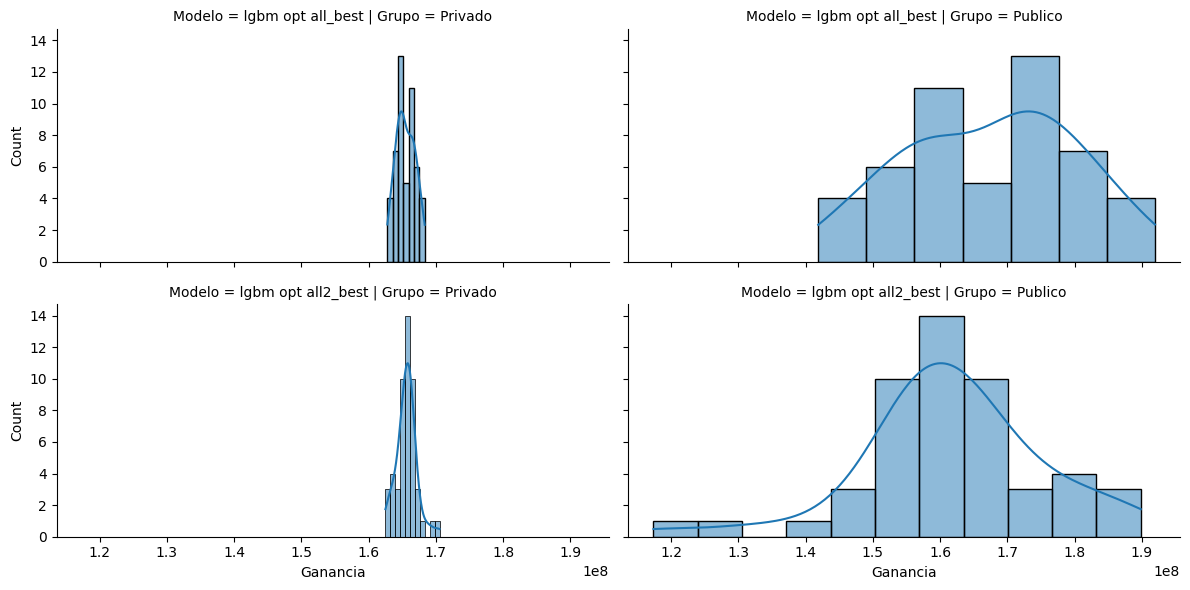

En estas condiciones, sin una nueva optimización, agregar lag2 y delta2 parece no influir en el performance.

## BACK-TESTING

### Back-testing comparando meses

Este procedimiento, que fue ejectado para la comp02, no fue repetida, ya que es evidente que más datos (contar con más meses en el train) mejora el aprendizaje de los modelos.

### Back-testing para evaluar semillerios

**Usando 10 meses de entranamiento** y testeando contra 202107.

Notebook: comp03_back-testing_sem

> **Modelo lgbm optimizado**

5 semilleríos de 10 semillas, muy costoso de entrenar por el tamaño del modelo.

De estas 50 iteraciones, agrupadas en promedio de a 10, se observa un umbrál optimo en 0.017 con 10888 estímulos, con ganancias máximas del orden de 165 millones:

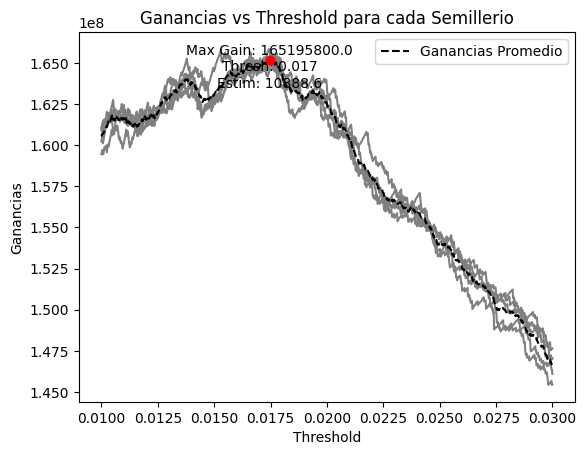

> **Modelo semillerio**

Semillerio de Denicolay (presentado en la clase plenaria)

10 semillerios con 25 semillas cada uno.

In [ ]:
semillero_params = {'n_estimators': 23,
                  'num_leaves': 32,
                  'learning_rate': 0.34,
                  'min_data_in_leaf': 711,
                  'feature_fraction': 0.2,
                  'extra_trees': False,
}

Se observa un rendimiento apenas superior, pero con un semillerio que da muy por debajo del óptimo:

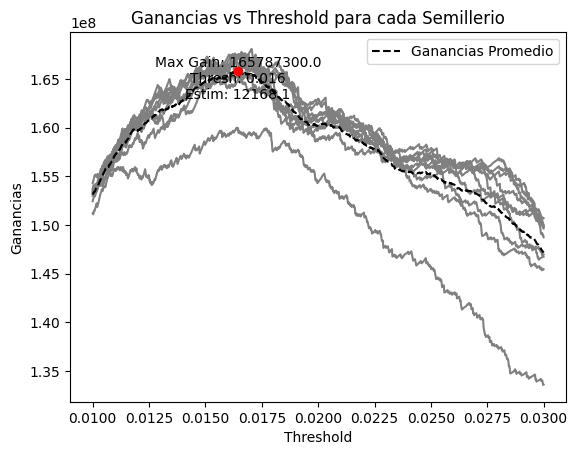

> **Modelo semillerio comp02**

Modelo optimizado en competencia 02.

5 semilleríos de 10 semillas, muy costoso de entrenar por el tamaño del modelo.

In [ ]:
opt_params = {'n_estimators': 464, 
            'max_leaves': 228, 
            'eta': 0.026841741174110256, 
            'gamma': 0.6065611085207565, 
            'min_child_weight': 10, 
            'subsample': 0.8649413237261332, 
            'colsample_bytree': 0.5013152719066779}

Se observa una ganancia un poco superio al resto, para un umbral de 0.017 y 12775 estímulos:

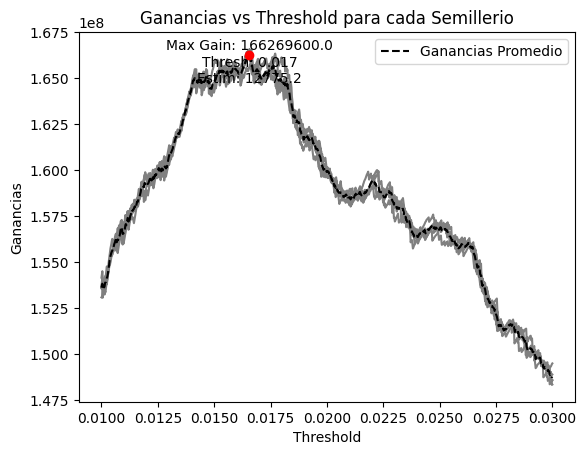

Comparación de semillerios:

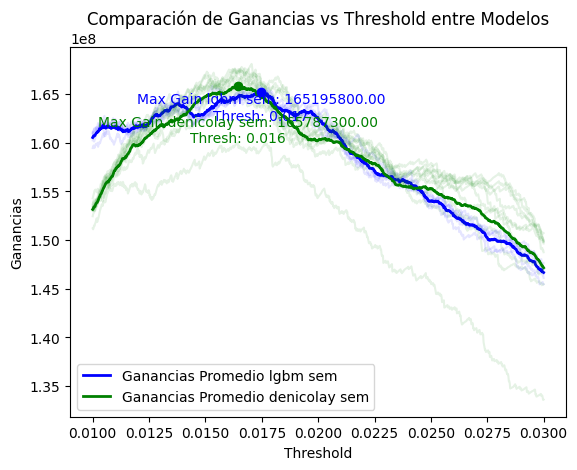

> CONCLUSIONES:

Se observa que ambos modelos son comparables, por lo que puedo concluir que mi optmización no es buena.

Además, parece que el xgb comp02 es superior a los lgbm semillerios promedio.

### Back-testing final

**Usando todos los meses de entranamiento**:

mes_bt_train_all = [
                    # 201901, 201902, 201903, 201904, 201906, 201907, # no los agregó por rotura de variables creadas
                    201908, 201909, 201911, 201912, 202001, 202002, 
                    202003, 202008, 202009, 202010, 202011, 202012,
                    202101, 202102, 202103, 202104, 202105
                    ] # igualmente habra variables perturbadas en los meses que no son tenidos en cuenta

vs. 202107

Notebook: comp03_back-testing_semxx

> **Modelo lgbm optimizado**

1 semilleríos de 10 semillas, muy costoso de entrenar por el tamaño del modelo. Da un óptimo mejor que lo visto hasta el momento, con un umbral de 0.018 y 11600 estímulos:

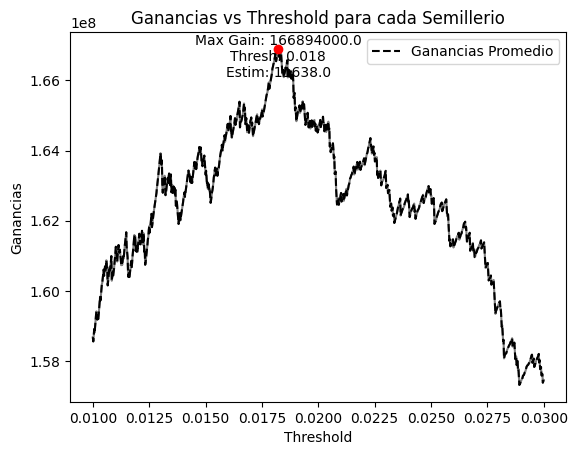

> **Modelo semillerio**

Semillerio de Denicolay (presentado en la clase plenaria)

1 semillerio con 100 semillas, también costoso en el entrenamiento. Da un óptimo similar al anterior, con cerca de 12000 estímulos.


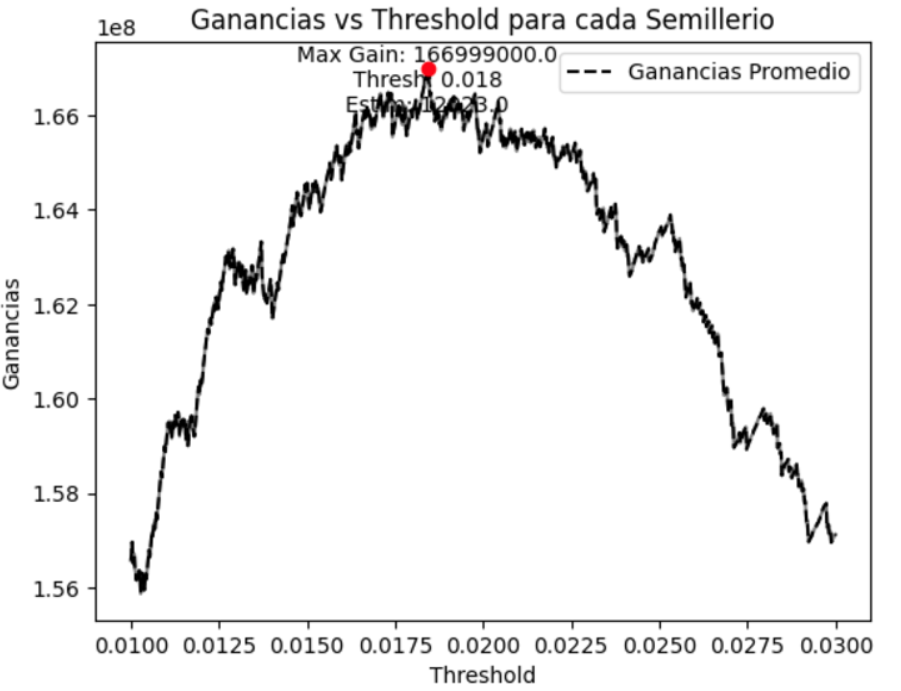

Comparación de semillerios:

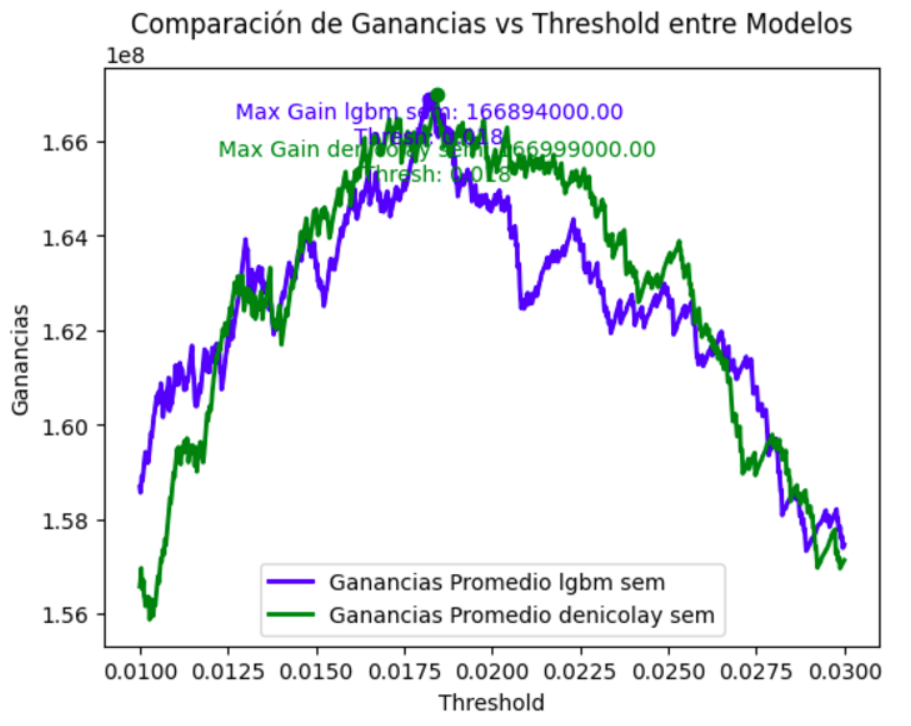

> CONCLUSION:

Los modelos son muy similares si miramos los máximos obtenidos, pero el modelo semillerio de Denicolay es más "estable" en umbrales entre 0.017 y 0.02.

> COMENTARIO:

Las ganancias estimadas en el back-testing parecen exageradas, según los resultados de la comp01 y comp02. Esto puede deberse a: 

- Cambios que hice en el pipeline de entrenamiento (a chequear)
- Sobre-ajuste de la optimización, ya que durante la misma usé el mes 202107 (ahora set de prueba)
- Situación particular/aleatoria del mes de 202107
- Podría estar cometiendo un error de data leakage, sumbido en un overfitting terrible :X@#

## Modelo elegido

> **Modelo semillerio denicolay**

Notebook: comp03_prediccionxx

In [ ]:
semillero_params = {'n_estimators': 23,
                  'num_leaves': 32,
                  'learning_rate': 0.34,
                  'min_data_in_leaf': 711,
                  'feature_fraction': 0.25,
                  'extra_trees': False,
}

## Uso de kaggle

comp03_kaggle_api_sub

> Uso de envíos a kaggle para inferir el umbral óptimo de los datos.

El resultado indica que el threshold a utilizar en la predicción final es superior a 0.019, con una cantidad de estímulos inferior a 12000. Según el Profesor, el mejor rendimiento ocurre para una cantidad de estímulos del orden de 10500 a 11500.

In [ ]:
###

____

## Mejunje de semillerios

Ante la afirmación de que combinar modelos diferentes puede traer mejor rendimiento, procedo a hacer un rejunte de probas de distintos modelos semillerios:

- xgb optimizado 25 semillas, datos regulares
- lgbm semillerio profe mod, 100 semillas, datos regulares (elegido como entrega única)
- lgbm semillerio profe original, 100 semillas, datos x

In [25]:
xgb_probas = 'predicciones/probas/probas_pred_xgb_pr6_fe6_op3_tr9_sem10_24T-11-202416-43-48.csv'
lgbm_mod_probas = 'predicciones/probas/probas_pred_lgbm_mod_pr6_fe6_tr9_sem100_24T-11-202417-29-53.csv'
lgbm_orix_probas = 'predicciones/probas/probas_pred_lgbm_pr6_fe6x_tr9_sem100_24T-11-202415-47-58.csv'

columns = ['client', 'proba_sem_mean']

df_xgb_probas = pd.read_csv(xgb_probas,usecols=columns)
df_lgbm_mod_probas = pd.read_csv(lgbm_mod_probas,usecols=columns)
df_lgbm_orix_probas = pd.read_csv(lgbm_orix_probas,usecols=columns)

df_mejunje = df_xgb_probas.merge(df_lgbm_mod_probas, on='client', suffixes=("_xgb","_lgbm_mod"))
df_mejunje = df_mejunje.merge(df_lgbm_orix_probas, on='client', how='left')

df_mejunje.rename(columns={'proba_sem_mean': 'proba_sem_mean_lgbm_orix'}, inplace=True)

In [26]:
df_mejunje

,client,proba_sem_mean_xgb,proba_sem_mean_lgbm_mod,proba_sem_mean_lgbm_orix
0,874396751,0.000189,0.000169,0.000163
1,433266268,0.000515,0.000843,0.001019
2,602940488,0.001893,0.002509,0.001931
3,311885150,0.000973,0.001813,0.000974
4,561051836,0.000367,0.000587,0.000493
...,...,...,...,...
165437,304459714,0.002948,0.001576,0.002026
165438,298978008,0.000208,0.000161,0.000187
165439,477851904,0.001995,0.001839,0.002163
165440,872832537,0.000529,0.000320,0.000416


In [36]:
proba_s_columns = df_mejunje.filter(regex='^proba_sem_mean_')
proba_s_mean = proba_s_columns.mean(axis=1)

df_mejunje['proba_sem_mean_all'] = proba_s_mean

# Umbral
thr_opt_sem = 0.015

# Prediccion
df_mejunje['pred'] = np.where(df_mejunje.proba_sem_mean_all >= thr_opt_sem, 1, 0)

In [37]:
submission = pd.DataFrame({
    'numero_de_cliente': df_mejunje.client.values,
    'Predicted': df_mejunje['pred'].values
})

# Imprimir value counts de las predicciones
value_counts = submission['Predicted'].value_counts()
total_count = len(submission)
print("\nValue Counts:")
print(value_counts)
print("\nFrecuencia Relativa:")
print((value_counts / total_count) * 100)

submission.info()


Value Counts:
Predicted
0    152285
1     13157
Name: count, dtype: int64

Frecuencia Relativa:
Predicted
0    92.047364
1     7.952636
Name: count, dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165442 entries, 0 to 165441
Data columns (total 2 columns):
 #   Column             Non-Null Count   Dtype
---  ------             --------------   -----
 0   numero_de_cliente  165442 non-null  int64
 1   Predicted          165442 non-null  int32
dtypes: int32(1), int64(1)
memory usage: 1.9 MB


In [31]:
import datetime

ft = "%dT-%m-%Y%H-%M-%S"
t_now = datetime.datetime.now().strftime(ft)

pred_name = f"pred_mejunje_"+t_now+".csv"

# Guardar el DataFrame en un archivo CSV
submission.to_csv('predicciones/'+pred_name, index=False)
print(f"Predicciones guardadas en{'predicciones/'+pred_name}")


Predicciones guardadas enpredicciones/pred_mejunje_24T-11-202418-18-06.csv


La intuición que tengo, según los comentarios de los Profesores, haría que elija esta predicción como entrega final, aunque debí hacer un back-testing acorde para probarlo.

El Profesor sopló que estaba overfitteando con esta entrega, por lo que volví a mi modelo elegido en las conclusiones.

_____